# Finding markets and optimal pricing policy for e-learning platform

![map](map.jpeg "map")

<div style="text-align: right"> Image source: vidiani.com 2021 </div>

## Introduction
Let's assume that we're working for an e-learning company that offers courses on programming. Most of our courses are on web and mobile development, but we also cover many other domains, like data science, game development, etc. 

Request from marketing team was to find out what countries to target in their new advertisement campaign and to identify the optimal pricing policy for the courses.


For the purpose of our analysis, I’d like to answer the following questions about a population of new coders that are interested in the subjects that been taught at the e-learning platform:

 - What are the locations with the greatest number of new coders?
 - How much money new coders are willing to spend on learning?

### Dataset

I am limited in resources so I can not organise a survey and have to rely on existing data sets.

I focus my attention on the data from freeCodeCamp 2017 [**New Coder Survey**](https://www.freecodecamp.org/news/we-asked-20-000-people-who-they-are-and-how-theyre-learning-to-code-fff5d668969/). 

[FreeCodeCamp](https://www.freecodecamp.org/) is a free e-learning platform that offers courses on web development. Because they regularly publish a number of popular [blogposts](https://www.freecodecamp.org/news/), their survey attracted new coders with varying interests (not only web development), which is ideal for the purpose of our analysis.

The survey data is available [in this GitHub repository](https://github.com/freeCodeCamp/2017-new-coder-survey).
 
## Sample exploration
 
 ### Explore data set and identify columns that will be used for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.style.use('fivethirtyeight')

In [2]:
survey = pd.read_csv('2017-fCC-New-Coders-Survey-Data.csv', dtype={'CodeEventOther': 'string', 'JobInterestOther': 'string'} )
survey.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18175 entries, 0 to 18174
Data columns (total 136 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    Age                            float64
 1    AttendedBootcamp               float64
 2    BootcampFinish                 float64
 3    BootcampLoanYesNo              float64
 4    BootcampName                   object 
 5    BootcampRecommend              float64
 6    ChildrenNumber                 float64
 7    CityPopulation                 object 
 8    CodeEventConferences           float64
 9    CodeEventDjangoGirls           float64
 10   CodeEventFCC                   float64
 11   CodeEventGameJam               float64
 12   CodeEventGirlDev               float64
 13   CodeEventHackathons            float64
 14   CodeEventMeetup                float64
 15   CodeEventNodeSchool            float64
 16   CodeEventNone                  float64
 17   CodeEventOther               

The survey presumably included a number of boxes to check showing what kind of coding events (columns with names starting from 'CodeEvent'), bootcamps ('AttendedBootcamp','BootcampFinish','BootcampLoanYesNo','BootcampName', 'BootcampRecommend') respondents participated as well as what resources (podcasts, youtube channels and e-learning platforms) they find useful for learning. If the person checked a box, it would get a '1' value, if not - NaN.

Also respondents provided demographic information (`Age`, `Gender`, `Income`, `IsEthnicMinority`)


Columns that could provide me with relevant for the question information:
 - `JobRoleInterest`
 - `CountryLive` where the person is located
 - `MoneyForLearning`, `AttendedBootcamp`
 
### Finding null values

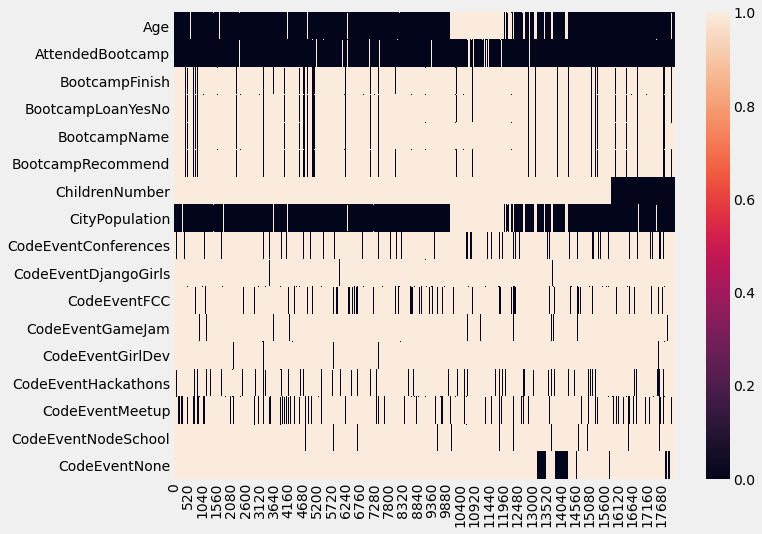

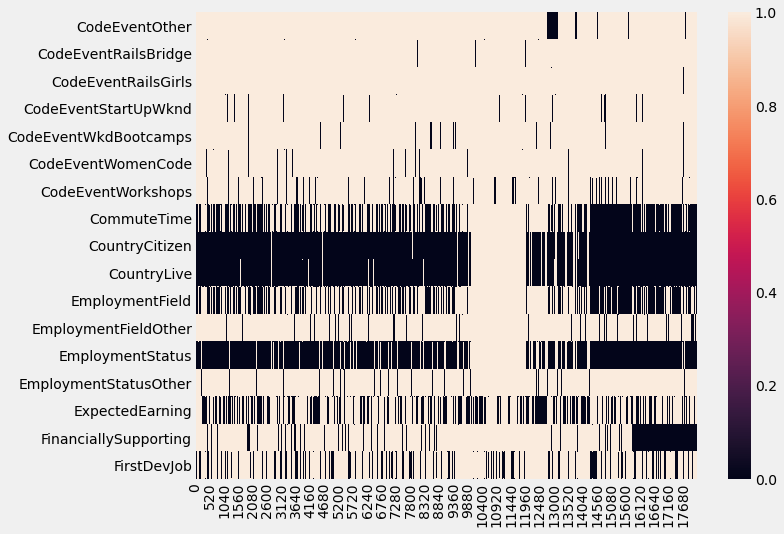

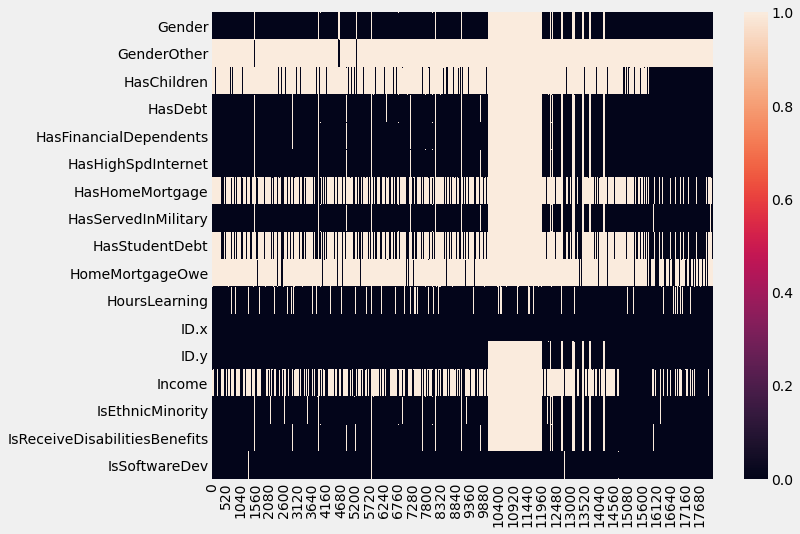

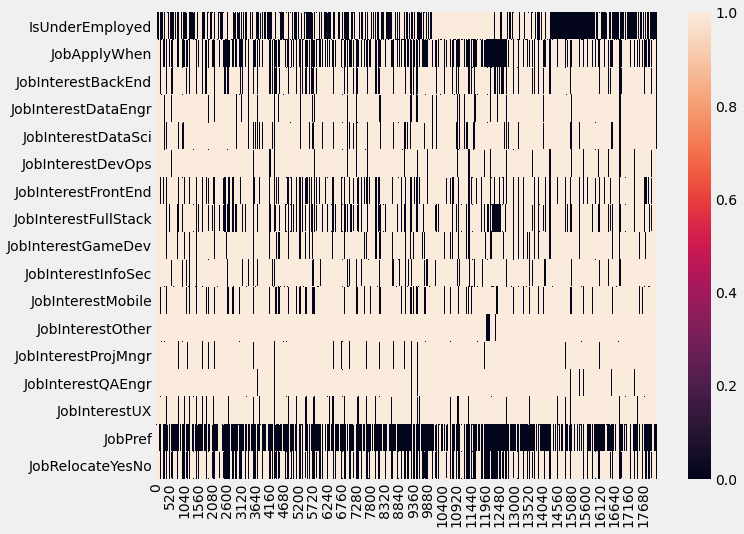

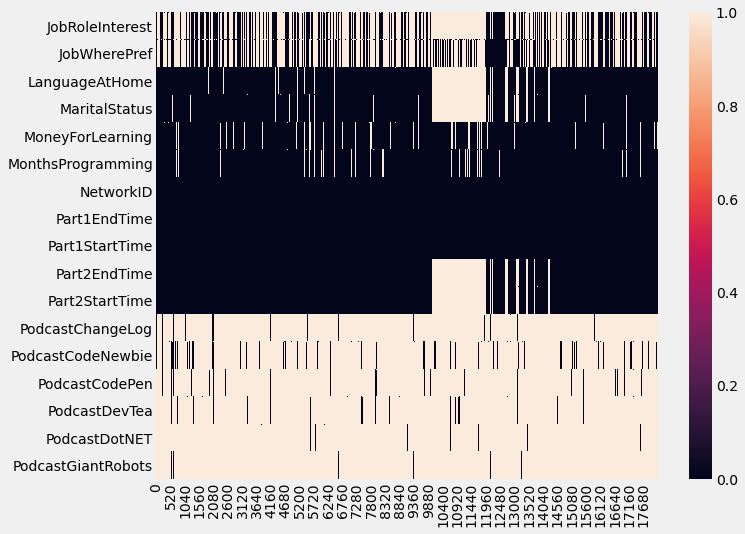

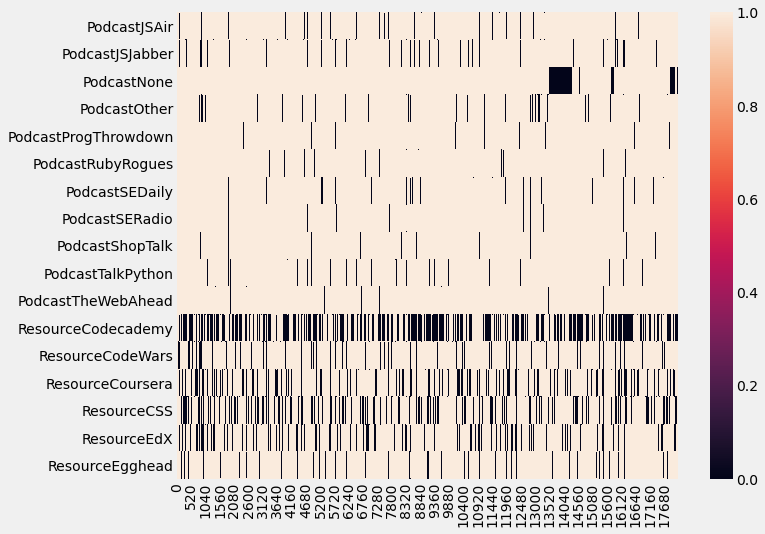

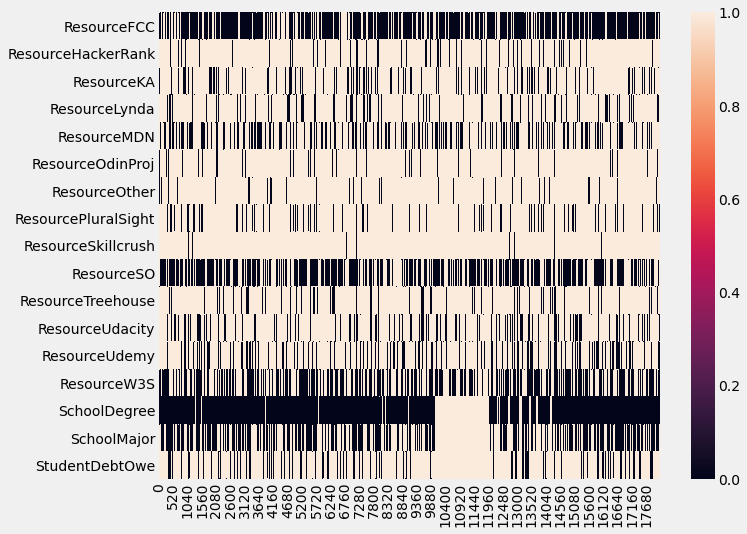

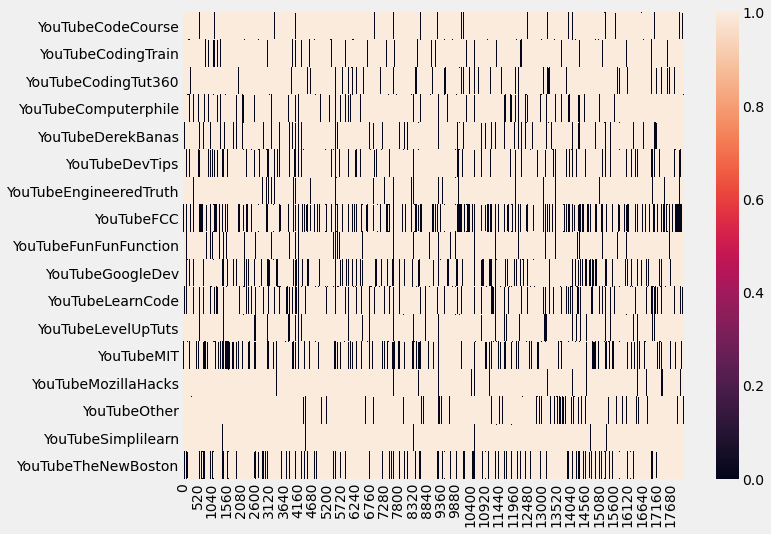

In [3]:
#visualize null values all over the file
for i in range(0, 136, 17):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(survey[survey.columns[i:i+17]].isnull().T, ax=ax, cbar='Blues')

In [4]:
# check for null values in JobRoleInterest
survey['JobRoleInterest'].value_counts(normalize=True, dropna=False)

NaN                                                                                                                                      0.615296
Full-Stack Web Developer                                                                                                                 0.045282
  Front-End Web Developer                                                                                                                0.024759
  Data Scientist                                                                                                                         0.008363
Back-End Web Developer                                                                                                                   0.007813
                                                                                                                                           ...   
  Front-End Web Developer, Full-Stack Web Developer,   User Experience Designer,   Quality Assurance Engineer, Back-End Web 

Huge share (circa 60%) of respondents didn't answer questions about their interests. Since I don't have a possibility to fill missing values I will delete them reducing my data set significantly.

In [5]:
# delete rows with null values in target fileds
survey_dev = survey.dropna(subset=['JobRoleInterest', 'CountryLive', 'MoneyForLearning']).copy()
survey_dev.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362 entries, 1 to 18171
Data columns (total 136 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    Age                            float64
 1    AttendedBootcamp               float64
 2    BootcampFinish                 float64
 3    BootcampLoanYesNo              float64
 4    BootcampName                   object 
 5    BootcampRecommend              float64
 6    ChildrenNumber                 float64
 7    CityPopulation                 object 
 8    CodeEventConferences           float64
 9    CodeEventDjangoGirls           float64
 10   CodeEventFCC                   float64
 11   CodeEventGameJam               float64
 12   CodeEventGirlDev               float64
 13   CodeEventHackathons            float64
 14   CodeEventMeetup                float64
 15   CodeEventNodeSchool            float64
 16   CodeEventNone                  float64
 17   CodeEventOther                

Reducing my dataset opens one very important question, if the sample that I have in the end is representative for the population?

## Is this survey a representative sample?
The focus of online courses is primarily but not exclusively on web and mobile development. Is there a match in interests with survey respondents?
Answering the survey respondents checked one or more boxes to choose which interests they have.

Let's see if they tend to choose only one or several fields of interest.

In [6]:
# prepare a list of interests
interest_list = survey_dev.columns[53:66].tolist()
interest_list.remove('JobInterestOther')
print(interest_list)

['JobInterestBackEnd', 'JobInterestDataEngr', 'JobInterestDataSci', 'JobInterestDevOps', 'JobInterestFrontEnd', 'JobInterestFullStack', 'JobInterestGameDev', 'JobInterestInfoSec', 'JobInterestMobile', 'JobInterestProjMngr', 'JobInterestQAEngr', 'JobInterestUX']


Text(0.5, 1.0, 'How many interests respondents chose')

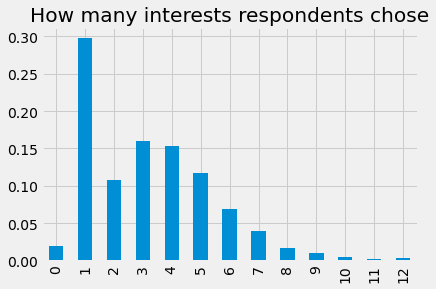

In [7]:
# count number of interests
survey_dev['nmb_interests'] = (survey_dev[interest_list]).sum(1.0).astype(int)

# create a bar plot with number of interests
survey_dev['nmb_interests'].value_counts(normalize=True).plot.bar()
plt.title('How many interests respondents chose')

30% of respondents specified only one interest while most of them chose more than one.

### Primal interest in development
The respondents of the survey have diverse interests. Which are their core interests? The target population should be primarily interested in web or mobile development. Does our sample follow that trend?

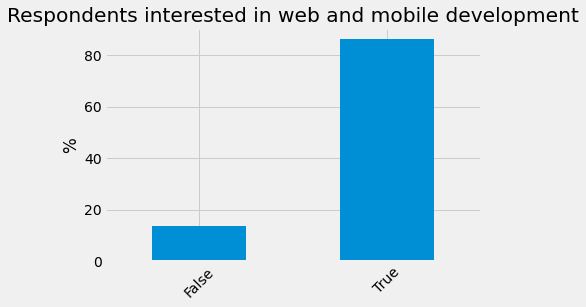

In [8]:
# fields of web and mobile development
dev = ['JobInterestBackEnd', 'JobInterestFrontEnd', 'JobInterestFullStack', 'JobInterestMobile']

# create bar plot
dev_interest = survey_dev[dev].any(axis='columns')
(dev_interest.value_counts(normalize=True)*100).plot.bar()
plt.title('Respondents interested in web and mobile development')
plt.ylabel('%')
plt.xticks(rotation = 45)

plt.show()

Indeed most part pf respondents (circa 85%) has interest in any filed of web or mobile development. 

### Full range of interests
Final step in identifiying if the sample matches good enough the target population is to check the full range of interests.

Text(0.5, 1.0, 'Interests of respondents (% from total)')

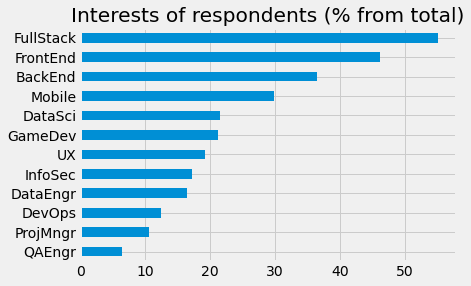

In [9]:
interests = pd.Series(dtype='float64')

#labels = [i.replace('JobInterest', '') for i in interest_list]

# calculate percetages for each field of interest
for i in interest_list:
    interests[i] = survey_dev[i].sum()/6992*100

interests.sort_values(ascending=True, inplace=True)
interests = interests.rename(lambda x: x.replace('JobInterest', ''))

# plot the distribution
interests.plot.barh()
plt.title('Interests of respondents (% from total)')

Now that we found out that the sample has the right categories of people for our purpose, we can begin analyzing it.  Next step is to start answering the following question: What are the locations with the greatest number of new coders?

## Identifying location and density of new coders

I'll start with finding out where these new coders are located, and what are the densities (how many coders there are) for each location.
Because the data set provides information at a country level, we can think of each country as an individual market. This means we can reframe our goal as **finding the two best countries to advertise in**.

One indicator of a good market is the *number of potential customers* — the more potential customers in a market.
Let's find the top countries with the most respondents.

Text(0.5, 1.0, 'Country where respondents live (in %)')

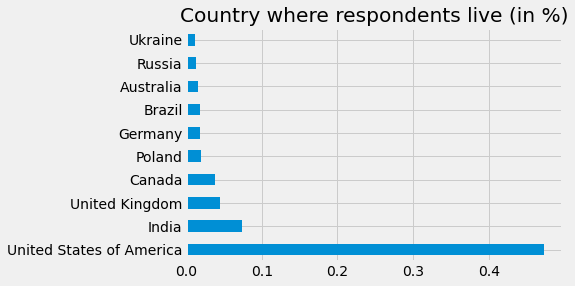

In [10]:
survey_dev.CountryLive.value_counts(normalize=True).head(10).plot.barh()
plt.title('Country where respondents live (in %)')

I've identifies top-4 of countries: USA (with circa 50% of respondents), India, UK and Canada.

##  How much money new coders are willing to spend on learning?

Advertising within markets where most people are only willing to learn for free is extremely unlikely to be profitable for us, so my aim is to find out how much money will respondents be willing to pay.

The `MoneyForLearning` column of the data set describes in American dollars the *amount of money spent by participants from the moment they started coding until the moment they completed the survey*. 

Baseline for subscription price at our platform is *$59 per month*, and for this reason I'm interested in finding out how much money each student spends *per month*.

It also seems like a good idea to narrow down our analysis to only top-4 countries: the US, India, the United Kingdom, and Canada. Two reasons for this decision are:

 - These are the countries having *the highest absolute frequencies in our sample*, which means we have a decent amount of data for each.
 - Our courses are *written in English*, and English is an official language in all these four countries. The more people that know English, the better our chances to target the right people with our ads.

In [11]:
# calculate spending per month
survey_dev['MonthsProgramming'].replace({0:1}, inplace=True)
survey_dev['spent_per_month'] = survey_dev['MoneyForLearning']/survey_dev['MonthsProgramming']

# check basic statistics
desc_stat = survey_dev['spent_per_month'].describe()
print(desc_stat)
print(int(desc_stat[1]))

count     6212.000000
mean       178.736963
std       1575.402837
min          0.000000
25%          0.000000
50%          0.711310
75%         33.333333
max      80000.000000
Name: spent_per_month, dtype: float64
178


### Iterative search for outliers

The maximum amount spent for learning is looking totally unrealistic. The median (50th percentile) is less than mean that also is a sign of significant skew of the distribution to right, that can be a result of outliers. 

Let's plot a boxplot to visualize the outliers for the whole sample.

Text(0.5, 1.0, '$ spent per month')

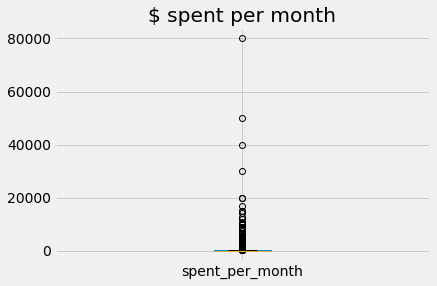

In [12]:
survey_dev['spent_per_month'].plot.box()
plt.title('$ spent per month')

Since the survey originated from the free code learning platform there it's not surprising that the predominant number of students prefer to use free resources for learning. 

Next step is to *look only at respondents who spent >0* on learning living in the countries with the largest number of new developers.

In [13]:
# filter data from top-4 countries
countries = (survey_dev['CountryLive'] == 'United States of America') | (survey_dev['CountryLive'] =='India') | (survey_dev['CountryLive'] == 'United Kingdom') | (survey_dev['CountryLive'] == 'Canada')
top_4 = survey_dev[countries]

# check descriptive statistics for top-4 countries
grouped = top_4.groupby('CountryLive')['spent_per_month']
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
CountryLive,,,,,,,,
Canada,240.0,113.510961,441.014158,0.0,0.0,0.000000,25.000000,5000.0
India,463.0,135.100982,692.960378,0.0,0.0,0.000000,13.250000,10000.0
United Kingdom,279.0,45.534443,162.311836,0.0,0.0,0.000000,20.416667,1400.0
United States of America,2933.0,227.997996,1940.245614,0.0,0.0,3.333333,50.000000,80000.0


The results for the United Kingdom and Canada are surprisingly low relative to the values we see for India. If we considered a few socio-economical metrics (like GDP per capita), we'd intuitively expect people in the UK and Canada to spend more on learning than people in India.

It might be that we don't have enough representative data for the United Kingdom, Canada, and India, or we have some outliers (maybe coming from wrong survey answers) making the mean too big for India, or too low for the UK and Canada. Or it might be that the results are correct.

Let's visualize the distribution for every country from the top-4 list.

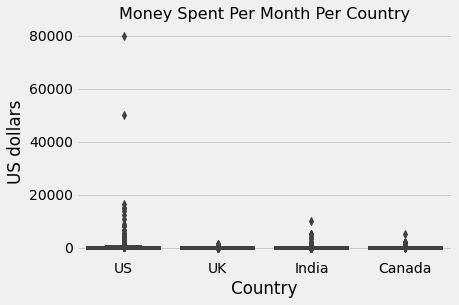

In [14]:
sns.boxplot(y = 'spent_per_month', x = 'CountryLive',
            data = top_4)
plt.title('Money Spent Per Month Per Country',
         fontsize = 16)
plt.ylabel('US dollars')
plt.xlabel('Country')
plt.xticks(range(4), ['US', 'UK', 'India', 'Canada']) # avoids tick labels overlap
plt.show()

In [15]:
# isolate clear outliers and zeros
clean_top_4 = top_4[(top_4['spent_per_month'] < 20000) & (top_4['spent_per_month'] > 0)]
grouped = clean_top_4.groupby('CountryLive')['spent_per_month']

# check descriptive staistics
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
CountryLive,,,,,,,,
Canada,114.0,238.970444,617.345854,0.416667,8.333333,25.000000,131.250000,5000.000000
India,201.0,311.202759,1026.728280,0.138889,5.500000,20.000000,133.333333,10000.000000
United Kingdom,137.0,92.730727,222.359671,0.050000,8.333333,20.833333,66.666667,1400.000000
United States of America,1617.0,333.159012,1142.847191,0.033333,10.000000,33.333333,166.666667,16666.666667


The data still shows that there are a number of upper outliers. Since the paying capability differs strongly among respondents from different countries from top-4, I'll visualize the distribution *separately*.

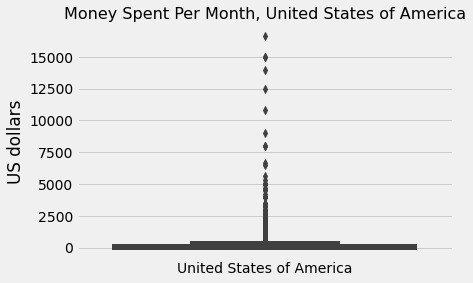

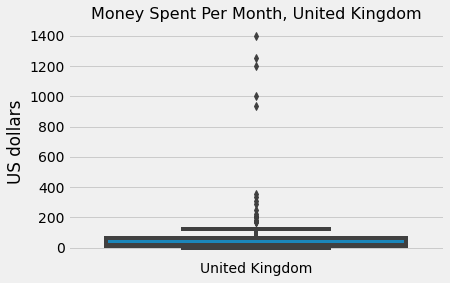

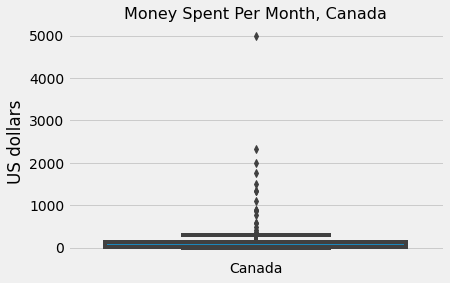

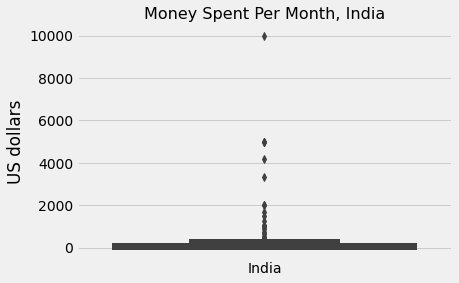

In [16]:
countries = clean_top_4.CountryLive.unique().tolist()

# create separate boxplot for every country from top-4
for c in countries:
    sns.boxplot(y = 'spent_per_month', x = 'CountryLive',
            data = clean_top_4[clean_top_4['CountryLive'] == c])
    plt.title('Money Spent Per Month, {}'.format(c),
         fontsize = 16)
    plt.ylabel('US dollars')
    plt.xlabel('')
    plt.show()

## Finding the balance
Let's have a look at every country from top-4 separately and check how our baseline price accords with mean spendings on learning there.

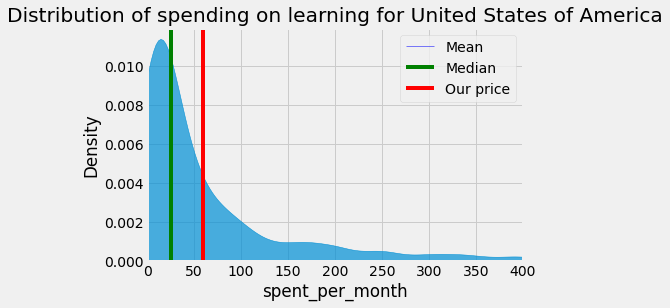

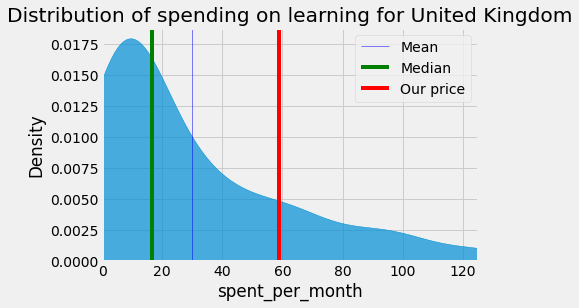

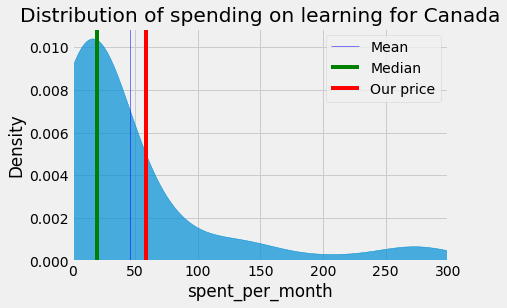

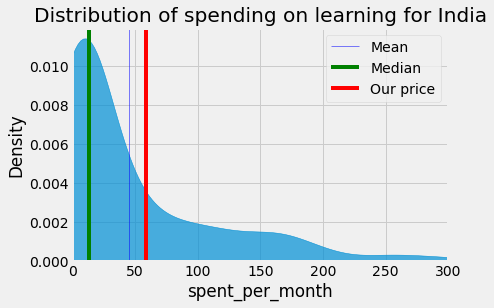

In [17]:
means = {}
for c in countries:
    
    country_set = clean_top_4[clean_top_4['CountryLive'] == c]
    
    # descriptive statistics for every country
    desc_stat = country_set['spent_per_month'].describe()
    IQR = desc_stat.iloc[6] - desc_stat.iloc[4]
    upper_outliers = int(desc_stat.iloc[6] + (1.5 * IQR))
    
    # isolate upper outliers
    no_outliers = country_set[country_set['spent_per_month'] <= upper_outliers]
    
    # kde plot for every country
    sns.kdeplot(x=no_outliers['spent_per_month'], fill=True, alpha=0.7)
    plt.xlim((0, no_outliers['spent_per_month'].max()))
    plt.title('Distribution of spending on learning for {}'.format(c))
    plt.axvline(x=no_outliers['spent_per_month'].mean(), label='Mean', color='b', linewidth=0.5)
    
    # add reference lines
    means[c] = no_outliers['spent_per_month'].mean()
    plt.axvline(x=no_outliers['spent_per_month'].median(), label='Median', color='g')
    plt.axvline(x=59, label='Our price', color='r')
    
    plt.legend()
    plt.show()

In [18]:
print(means)

{'United States of America': 60.32277969777555, 'United Kingdom': 29.793656470617254, 'Canada': 45.72471377499079, 'India': 45.628948927008594}


# Choosing the Two Best Markets

The first obvious choice for our campaign is **USA**. There are many new coders who reside there and they are capable of paying a reasonably high amount of money ($60 in average).

**India and Canada** seem to be both good options since new coders from there could pay for subscription is $45 on average. I would recommend focus on **India** since it's the second biggest market by size.

At this point I would recommend split the budget relatively the size of the markets:
 - 80% for USA and 20% for India
 
Or split remainder of the budget to Canada and India:

 - 60% for USA and 20% for India and Canada
 - 60% for USA, 30% for India and 10% for Canada